In [1]:
# 1.1 셔플된 MNIST 데이터에서 KNN 분류기

### A. 1-NN의 MNIST의 오분류 확률이 앞의 천개의 데이터에서 3.8%, 전체 데이터(만개)에서 3.09%임을 증명하라
### B. 컬럼 순서를 임의로 변경하여도 에러율은 변경되지 않음을 증명하라

In [2]:
from scipy import io

data = io.loadmat('../pmtk3/bigData/mnistAll/mnistAll.mat')['mnist'][0][0]
data_cat = ['train_data', 'test_data', 'train_label', 'test_label']

for i in range(4):
    print(data_cat[i], ":", data[i].shape)

train_data : (28, 28, 60000)
test_data : (28, 28, 10000)
train_label : (60000, 1)
test_label : (10000, 1)


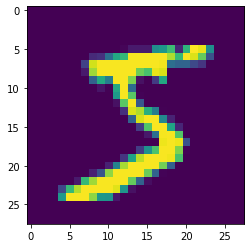

In [3]:
import matplotlib.pyplot as plt

plt.imshow(data[0][:,:,0])
plt.show()

In [4]:
import numpy as np

def euclidean_distance(a, b):
    return np.sqrt(np.sum(a * a + b * b - 2 * a * b))

assert euclidean_distance(np.array([0, 0]), np.array([1,1])) == np.sqrt(2)

def np_matadd(a, b):
    a_expanded = np.hstack([a, np.ones(a.shape)])
    b_expanded = np.hstack([np.ones(b.shape), b])
    return np.matmul(a_expanded, b_expanded.T)

assert (np_matadd(np.array([[0, 1], [2, 3], [4, 5], [6, 7]]), np.array([[0, 1], [2, 3]])) == np.array([[2, 6], [6, 10], [10, 14], [14, 18]])).all()

class KNN:
    def __init__(self, k):
        self.k = k

    def fit(self, data, label):
        self.data = data # 2d array
        self.label = label
        self.labels = np.array(list(set(self.label)))
        self.labels.sort()
    
    def predict_one(self, x):
        distance_square = np.sum(self.data * self.data + x * x - 2 * self.data * x, axis=1) # 상대적인 길이 비교를 하면되기 때문에 거리의 제곱 값으로 비교
        argmax_index = distance_square.argsort()[:self.k] # 거리 값이 낮은 k개의 index를 선택
        nearest_label = self.label[argmax_index] # 가까운 k개 노드들의 Label의 집합을 구함
        labels, count = np.unique(nearest_label, return_counts=True) # label들의 개수를 카운트
        return labels[np.argmax(count)] # 개수가 가장 많은 label을 출력
    
    def predict(self, X):
        a_square = X * X
        b_square = self.data * self.data
        distance_square = np_matadd(a_square, b_square) - 2 * np.matmul(X, self.data.T)
        argmax_index_2d = distance_square.argsort(axis=1) # 거리 값이 낮은 k개의 index를 선택
        
        result = []
        for i in range(X.shape[0]):
            argmax_index = argmax_index_2d[i, :self.k]
            nearest_label = self.label[argmax_index] # 가까운 k개 노드들의 Label의 집합을 구함
            labels, count = np.unique(nearest_label, return_counts=True) # label들의 개수를 카운트
            result.append(labels[np.argmax(count)]) # 개수가 가장 많은 label을 반환
        return np.array(result)
    
    def predict_proba(self, X):
        a_square = X * X
        b_square = self.data * self.data
        distance_square = np_matadd(a_square, b_square) - 2 * np.matmul(X, self.data.T)
        argmax_index_2d = distance_square.argsort(axis=1) # 거리 값이 낮은 k개의 index를 선택
        
        result = np.zeros((X.shape[0], self.labels.shape[0]))
        for i in range(X.shape[0]):
            argmax_index = argmax_index_2d[i, :self.k]
            nearest_label = self.label[argmax_index] # 가까운 k개 노드들의 Label의 집합을 구함
            labels, count = np.unique(nearest_label, return_counts=True) # label들의 개수를 카운트
            
            for l, c in zip(labels, count):
                result[i, np.where(self.labels == l)] = c * 1.0 / sum(count)
        return result


### KNN test code
test_data = np.array([[-2, 0],
                      [-1, 0],
                      [0, 0],
                      [2, 0],
                      [2, 1],
                      [2, 2]])
test_label = np.array([0, 0, 0, 1, 1, 1])
knn_model = KNN(3)
knn_model.fit(test_data, test_label)
assert knn_model.predict_one(np.array([0, 1])) == 0
assert knn_model.predict_one(np.array([1, 0])) == 1
assert knn_model.predict_one(np.array([2, 3])) == 1
assert (knn_model.predict(np.array([[0, 1], [1, 0], [2, 3]])) == np.array([0, 1, 1])).all()
assert (knn_model.predict_proba(np.array([[1, 0], [2, 3]])) == np.array([[1.0 / 3, 2.0 / 3], [0, 1]])).all()

def accuracy(a, b):
    return np.sum(a == b) * 1.0 / a.shape[0]
assert accuracy(np.array([1, 1, 1, 1]), np.array([1, 1, 1, 1])) == 1.0
assert accuracy(np.array([1, 0, 1, 1]), np.array([1, 1, 0, 1])) == 0.5
assert accuracy(np.array([1, 1, 1]), np.array([0, 0, 0])) == 0.0

In [5]:
### solution A
train_data, test_data, train_label, test_label = data
train_data = np.transpose(train_data, (2, 0, 1))
train_data = train_data.reshape(-1, 28 * 28)
train_data = np.array(train_data, dtype='int64')
test_data = np.transpose(test_data, (2, 0, 1))
test_data = test_data.reshape(-1, 28 * 28)
test_data = np.array(test_data, dtype='int64')
train_label = train_label.reshape(-1)
test_label = test_label.reshape(-1)

knn_model = KNN(3)
knn_model.fit(train_data, train_label)

pred = knn_model.predict(test_data[:1000, :])
acc1000 = accuracy(test_label[:1000], pred)
assert np.abs((1 - acc1000) - 0.038) < 0.1 ** 8

pred = knn_model.predict(test_data)
acc10000 = accuracy(test_label, pred)
assert np.abs((1 - acc10000) - 0.0295) < 0.1 ** 8 # 책 예제에는 0.0309로 나오는데...?

In [6]:
### Solution B

feature_order = np.arange(train_data.shape[1])
np.random.shuffle(feature_order)

train_data = train_data[:, feature_order]
test_data = test_data[:, feature_order]

knn_model = KNN(3)
knn_model.fit(train_data, train_label)

pred = knn_model.predict(test_data[:1000, :])
acc1000 = accuracy(test_label[:1000], pred)
assert np.abs((1 - acc1000) - 0.038) < 0.1 ** 8

In [7]:
### Additional Experiment
##### 직접 작성한 KNN 클래스의 처리 속도와 sklearn KNN 클래스의 처리 속도 비교

import time
from sklearn.neighbors import KNeighborsClassifier

custom_start = time.time()
knn_model = KNN(3)
knn_model.fit(train_data, train_label)

custom_pred = knn_model.predict(test_data[:1000, :])
custom_end = time.time()

print("custom KNN process time : ", custom_end - custom_start)

sklearn_start = time.time()
model = KNeighborsClassifier(n_neighbors=3)
model.fit(train_data, train_label)

sklearn_pred = model.predict(test_data[:1000, :])
sklearn_end = time.time()

print("sklearn KNN process time : ", sklearn_end - sklearn_start)

print("different predict count : ", np.sum(custom_pred != sklearn_pred))

custom KNN process time :  387.1575629711151
sklearn KNN process time :  101.43683624267578
different predict count :  0
